In [2]:
# This project focuses on brain CT image segmentation and denoising using Deep Learning.
# Al Smith and Will Newman
# c 2024

# Importing the necessary libraries:
import pydicom
from collections import defaultdict
import numpy as np
import zipfile
import random
import os
import gc
import sys
from glob import glob
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, IntSlider
from scipy.ndimage import label
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom


## Tasks:
1) Load data from CQ500
    * Download from: http://headctstudy.qure.ai/dataset
    * Explore the DICOM Header for voxel size and imaging information (ideally the CT machine model)
    * Resolution, dose, parameters, etc.
2) Preprocess the data (noise addition, downsampling, agumentation, etc)
    * 2a) Add noise similar to low-resolution CT
    * 2b) Downsample the images to lower-resolution scale
    * 2c) Split data into train/test sets
3) Build a 3D U-Net model for segmentation
    * 3a) start with training the model on CQ500 and normal masks
    * 3b) train the model on CQ500 with noise added
    * 3c) train the model on CQ500 with images processed by denoising model
4) Denoising Model for noisy CT images
5) Train the model
6) Evaluate the model

In [6]:
# Global Variables
lb = 1040
ub = 1080

In [7]:
def save_nifti(mask, output_dir, series_uid):
    """Save the mask as a NIfTI file."""
    nifti_image = nib.Nifti1Image(mask.astype(np.int16), affine=np.eye(4))
    nib.save(nifti_image, os.path.join(output_dir, f'{series_uid}_mask.nii'))

In [8]:
# Apply window and level to a 2D numpy array of DICOM data
def apply_window_level(data, lb, ub):
    windowed_data = np.clip(data, lb, ub)
    normalized_data = (windowed_data - lb) / (ub - lb)  # Normalize between 0 and 1
    return normalized_data

# Remove unnecessary CSF spaces from the mask
def remove_mask_below_slice(volume_mask, slice_index):
    """
    Set the mask to False for all slices below the specified index.

    Parameters:
    - volume_mask: 3D numpy array (boolean) of the mask.
    - slice_index: Integer, the index below which the mask should be removed.
    """
    # Set all slices below the specified index to False
    volume_mask[:slice_index, :, :] = False
    return volume_mask


In [9]:
# Largest connected component segmentation
def create_spherical_mask(shape, center, radius):
    z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
    dist_from_center = (z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2
    return dist_from_center <= radius**2


def largest_connected_component_3d(volume_data, lb, center, radius, threshold=0.4):
    """
    Find the largest connected component in a 3D volume that intersects with a specified spherical region.

    Parameters:
    - volume_data: 3D numpy array of DICOM data.
    - lb: Lower bound to create a binary mask for values of interest.
    - center: Tuple, the center coordinates (z, y, x) of the volume.
    - radius: Integer, the radius used to define the spherical region.

    Returns:
    - 3D mask (boolean array) of the same shape as volume_data for the largest component intersecting the sphere.
    """
    # Generate the binary mask
    slice_index = int(volume_data.shape[0] * 0.4)
    binary_mask = volume_data < lb
    binary_mask = remove_mask_below_slice(binary_mask, slice_index)

    # Label all components
    labeled_volume, num_features = label(binary_mask)
    if num_features == 0:
        return np.zeros_like(volume_data, dtype=bool)  # No components found

    # Generate the spherical mask
    spherical_mask = create_spherical_mask(volume_data.shape, center, radius)

    # Find labels intersecting the spherical mask
    intersecting_labels = np.unique(labeled_volume[spherical_mask])

    # Calculate the size of each intersecting component and select the largest
    largest_label = None
    max_size = 0
    for label_idx in intersecting_labels:
        if label_idx == 0:
            continue  # Skip background
        component_mask = labeled_volume == label_idx
        component_size = np.sum(component_mask)
        if component_size > max_size:
            max_size = component_size
            largest_label = label_idx

    return labeled_volume == largest_label if largest_label is not None else np.zeros_like(volume_data, dtype=bool)


In [10]:
def load_dicom_series_volumes(base_directory, idx):
    series_volumes = defaultdict(list)
    # Track the number of DICOM files processed
    dicom_file_count = 0
    
    # Construct the directory path
    case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
    
    if os.path.exists(case_dir):
        # Walk through all files in the series directories within the "Unknown Study" directory
        for root, dirs, files in os.walk(case_dir):
            for dir in dirs:
                series_path = os.path.join(root, dir)
                slices = []
                # Collect all DICOM slices in the series directory
                for slice_file in os.listdir(series_path):
                    if slice_file.lower().endswith('.dcm'):
                        full_path = os.path.join(series_path, slice_file)
                        try:
                            # Read the DICOM file
                            dicom_slice = pydicom.dcmread(full_path)
                            # Append the slice and its position for later sorting
                            slices.append((dicom_slice, dicom_slice.ImagePositionPatient[2]))
                            dicom_file_count += 1
                        except Exception as e:
                            print(f"Failed to read {slice_file} as DICOM: {e}")

                # Sort slices based on the z-coordinate (ImagePositionPatient[2])
                slices.sort(key=lambda x: x[1])
                # Stack the pixel data from sorted slices to form a 3D volume
                if slices:
                    series_uid = slices[0][0].SeriesInstanceUID
                    volume = np.stack([s[0].pixel_array for s in slices])
                    series_volumes[series_uid].append(volume)

                    center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
                    radius = int(volume.shape[0] // 6)  # Define the radius as desired

                    # Generate mask and save
                    mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
                    save_nifti(mask, case_dir, series_uid)
                    print("Saved mask to ", case_dir)
    else:
        print(f"Directory does not exist: {case_dir}")

    print(f"Processed {dicom_file_count} DICOM files.")
    return series_volumes

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted'  # Adjust this path
dicom_volumes = load_dicom_series_volumes(base_directory, 2)
print(f"Number of series with loaded volumes: {len(dicom_volumes)}")

Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT2 CQ500CT2/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT2 CQ500CT2/Unknown Study
Processed 288 DICOM files.
Number of series with loaded volumes: 2


# DICOM Directories that are useful
* Series Number    0, 3, 4, 5, 7, 9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63, 64, 70, 71, 76, 78, 79, 81, 82, 83, 84, 85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 106, 109, 113, 116, 117
* Number of Masks: 5, 2, 1, 1, 1, 2,  2,  1,  4,  2,  3,  2,  2,  3,  2,  2,  2,  1,  1,  1,  1,  1,  2,  3,  1,  2,  2,  3,  1,  2,  2, 1,   1,   1,  1,  1,  1,  3,  3,  1,  4,  1,   2,   3,   1,   2,   1,   3,   4,   2,   2,   1,   3

# DICOM Directories with surgical pathology (less useful)
* Series Number    2, 6, 10, 11, 17, 18, 20, 22, 34, 48, 55, 57, 60, 64, 66, 68, 86, 90, 108, 111, 114,
* Number of Masks: 2, 3,  1,  2,  2,  2,  2,  2,  3,  4,  2,  2,  4,  1,  5,  2,  2,  2,   2,   2,   1,

In [11]:
# Visualize Loaded DICOM Data

# Assume dicom_volumes is already loaded
series_selection =  0
dicom =             2
series_uid = list(dicom_volumes.keys())[series_selection]
print(series_uid)
volume = dicom_volumes[series_uid][0]  # Get the first volume of the first series

center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
radius = int(volume.shape[0] // 6)  # Define the radius as desired
#volume_mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
volume_mask = nib.load(f'/media/hal9000/Database/CQ500_extracted/CQ500CT{dicom} CQ500CT{dicom}/Unknown Study/{series_uid}_mask.nii').get_fdata() > 0

# Function to display a single slice
def view_slice(slice_index):
    plt.figure(figsize=(4, 4))
    processed_image = apply_window_level(volume[slice_index], lb, ub)
    
    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(processed_image.shape + (4,))  # RGBA
    overlay[..., 0] = 1.0  # Red channel
    overlay[..., 3] = volume_mask[slice_index] * 0.5  # Semi-transparent where the mask is True

    plt.imshow(processed_image, cmap='gray')
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    plt.show()

# Slider to select the slice index
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=volume.shape[0] - 1,  # max slice index
    step=1,
    description='Slice Index:',
    continuous_update=True
)

# Use ipywidgets' interactive functionality to bind the slider and the display function
widgets.interactive(view_slice, slice_index=slice_slider)

1.2.276.0.7230010.3.1.3.296485376.1.1521713579.1849135


interactive(children=(IntSlider(value=0, description='Slice Index:', max=255), Output()), _dom_classes=('widge…

In [554]:
# Visualize the CSF Space Segmentation Mask in 3D dynamic viewer
def visualize_3d_mask(volume_mask):
    """Visualize a 3D mask using mayavi's volume rendering capabilities."""
    # Create a figure
    fig = mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))
    
    # Visualize the volume mask: 1s are turned to True, 0s to False
    src = mlab.pipeline.scalar_field(volume_mask.astype(int))
    # Threshold to visualize only the 1s
    mlab.pipeline.iso_surface(src, contours=[volume_mask.min()+0.5, volume_mask.max()], opacity=0.4, color=(1, 0, 0))
    
    # Enhance the view
    mlab.view(azimuth=180, elevation=180, distance=400)
    mlab.roll(180)
    
    # Add axes and outline for better visual orientation
    mlab.outline(src, color=(1, 1, 1))
    mlab.axes(src, color=(1, 1, 1), xlabel='X', ylabel='Y', zlabel='Z')

    # Show the plot
    mlab.show()

# Assuming volume_mask is the mask calculated earlier
visualize_3d_mask(volume_mask)

In [12]:
# Task #1 Convert loaded data into torch training and validation datasets
def load_dicom_series_volumes(base_directory, indices, target_size=(32, 128, 128)):
    series_data = defaultdict(lambda: {'images': None, 'mask': None})

    for idx in indices:
        case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
        print(f"Searching in: {case_dir}")

        if os.path.exists(case_dir):
            mask_files = {os.path.basename(f).split('_mask.nii')[0]: f for f in glob(os.path.join(case_dir, '*_mask.nii'))}

            for subdir in os.listdir(case_dir):
                subdir_path = os.path.join(case_dir, subdir)
                if not os.path.isdir(subdir_path):
                    continue

                slices = []
                series_uid = None
                for slice_file in glob(os.path.join(subdir_path, '*.dcm')):
                    try:
                        dicom_slice = pydicom.dcmread(slice_file)
                        slices.append(dicom_slice)
                        series_uid = dicom_slice.SeriesInstanceUID
                    except Exception as e:
                        print(f"Failed to read {slice_file} as DICOM: {e}")

                if slices and series_uid:
                    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                    volume = np.stack([s.pixel_array for s in slices])

                    # Resize the volume
                    resize_factor = np.array(target_size) / np.array(volume.shape)
                    resized_volume = zoom(volume, resize_factor)
                    series_data[series_uid]['images'] = resized_volume

                    if series_uid in mask_files:
                        mask_file = mask_files[series_uid]
                        mask = nib.load(mask_file).get_fdata()

                        # Resize the mask
                        resized_mask = zoom(mask, resize_factor)
                        resized_mask = (resized_mask > 0.5).astype(np.float32)
                        series_data[series_uid]['mask'] = resized_mask
                        print(f"Mask found and loaded for series UID {series_uid}")
        else:
            print(f"No directory found for index {idx}")

    filtered_data = {uid: data for uid, data in series_data.items() if data['images'] is not None and data['mask'] is not None}
    return filtered_data

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted/'
# all indices from "good scans", where first comment is 10 scans, second is 64, and third is 100, spaces indicate where to comment out
indices = [0, 3, 4, 5, 7     , 9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63]#, 64, 70, 71, 76, 78, 79, 81, 82, 83, 84] #, 85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 106, 109, 113, 116, 117]
loaded_data = load_dicom_series_volumes(base_directory, indices)
print(f"Loaded {len(loaded_data)} series with both images and masks.")

Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152


In [42]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """
    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
        # Show the mask slice
        ax.imshow(image_volume[slice_index], cmap='gray')
        ax.imshow(mask_volume[slice_index], alpha=0.5, cmap='Reds')  # Overlay mask
        ax.set_title('Image with Mask')
        ax.axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

# Example usage with the first loaded series (assuming loaded_data is available)
series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series
visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'])

interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

In [4]:
class CTScanDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        uid, data = list(self.data.items())[idx]
        image = np.array(data['images'])  # Convert memmap to regular numpy array
        mask = np.array(data['mask'])  # Convert memmap to regular numpy array
        return image, mask

In [51]:
# Define a custom collate function

batch_size = 4

def collate_fn(batch):
    images, masks = zip(*batch)
    
    # Convert the numpy arrays to PyTorch tensors
    images = [torch.from_numpy(image.astype(np.float32)) for image in images]
    masks = [torch.from_numpy(mask.astype(np.uint8)) for mask in masks]
    
    # Determine the maximum size along the 0 axis
    max_size = max(image.shape[0] for image in images)
    
    # Pad the images and masks to the maximum size
    images = [F.pad(image.float(), (0, 0, 0, 0, 0, max_size - image.shape[0])) for image in images]
    masks = [F.pad(mask.float(), (0, 0, 0, 0, 0, max_size - mask.shape[0])) for mask in masks]
    
    return torch.stack(images), torch.stack(masks)

# Data Split
def create_train_test_split(data_dict, test_size=0.25, random_state=42):
    # Create a list of keys, which are the series UIDs
    series_uids = list(data_dict.keys())
    
    # Split the series UIDs into train and test sets
    train_uids, test_uids = train_test_split(series_uids, test_size=test_size, random_state=random_state)
    
    # Create subsets for train and test from the main dataset
    train_dataset = {uid: data_dict[uid] for uid in train_uids}
    test_dataset = {uid: data_dict[uid] for uid in test_uids}
    
    return train_dataset, test_dataset

# Assume 'loaded_data' is your fully loaded dataset dictionary
train_data, test_data = create_train_test_split(loaded_data, test_size=0.4)

# Assuming a transform defined earlier
train_dataset = CTScanDataset(train_data)
test_dataset = CTScanDataset(test_data)

# Create DataLoaders for both train and test datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Task #2 Preprocess the data
# Task #2b Add noise similar to low-resolution CT

# Task #2c Downsample the images to lower-resolution scale

# Task #2d Split the data into training and testing sets

In [ ]:
# Task #3 Build a 3D U-Net model for segmentation
# Task #3a Start with training the model on CQ500 and normal masks

# Task #3b Train the model on CQ500 with noise added

# Task #3c Train the model on CQ500 with images processed by denoising model

In [44]:
# Task 3 Using nnU-Net architecture as described in the paper: https://arxiv.org/abs/2404.09556

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffZ = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffY = torch.tensor([x2.size()[3] - x1.size()[3]])
        diffX = torch.tensor([x2.size()[4] - x1.size()[4]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see below
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(768, 256, bilinear)
        self.up2 = Up(384, 128, bilinear)
        self.up3 = Up(192, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [110]:
# Use Sørensen-Dice coefficient as the loss function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert probabilities to binary predictions
        # For a multi-class problem, consider each class channel as a binary problem
        inputs = F.sigmoid(inputs)  # Apply sigmoid to squash outputs to [0,1]
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = UNet3D(n_channels=1, n_classes=1).to(device)
#criterion = DiceLoss()
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
loss = 0.0
loss_history = []
val_loss_history = []
def to_grayscale(images):
    return images.mean(dim=1, keepdim=True).squeeze(1)

Device:  cuda


In [96]:
# garbace collection to prevent gpu memory overflow
gc.collect()
model = None
torch.cuda.empty_cache()

In [112]:
# Training Loop
squeeze_factor = 1

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_val_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, masks) in progress_bar:
        images = images.float().to(device)
        masks = masks.float().to(device)

        images = images.unsqueeze(squeeze_factor)
        masks = masks.unsqueeze(squeeze_factor)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=images.size()[2:])
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del images, masks, outputs
        torch.cuda.empty_cache()

        # Update the progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_history.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (images, masks) in enumerate(test_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            images = images.unsqueeze(squeeze_factor)
            masks = masks.unsqueeze(squeeze_factor)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item()

        # Calculate the average validation loss for the epoch
        average_val_loss = running_val_loss / len(test_loader)
        val_loss_history.append(average_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {average_val_loss:.4f}")

Epoch 1/100:   0%|          | 0/2 [00:00<?, ?it/s]/home/hal9000/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1/100: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.992]


Epoch [1/100], Average Loss: 0.9941
Epoch [1/100], Average Validation Loss: 0.9964


Epoch 2/100: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.994]


Epoch [2/100], Average Loss: 0.9925
Epoch [2/100], Average Validation Loss: 0.9963


Epoch 3/100: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.988]


Epoch [3/100], Average Loss: 0.9901
Epoch [3/100], Average Validation Loss: 0.9961


Epoch 4/100: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.992]


Epoch [4/100], Average Loss: 0.9905
Epoch [4/100], Average Validation Loss: 0.9955


Epoch 5/100: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=0.992]


Epoch [5/100], Average Loss: 0.9899
Epoch [5/100], Average Validation Loss: 0.9946


Epoch 6/100: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.991]


Epoch [6/100], Average Loss: 0.9895
Epoch [6/100], Average Validation Loss: 0.9934


Epoch 7/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.989]


Epoch [7/100], Average Loss: 0.9886
Epoch [7/100], Average Validation Loss: 0.9928


Epoch 8/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.989]


Epoch [8/100], Average Loss: 0.9884
Epoch [8/100], Average Validation Loss: 0.9923


Epoch 9/100: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s, loss=0.985]


Epoch [9/100], Average Loss: 0.9873
Epoch [9/100], Average Validation Loss: 0.9916


Epoch 10/100: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=0.985]


Epoch [10/100], Average Loss: 0.9872
Epoch [10/100], Average Validation Loss: 0.9911


Epoch 11/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.99] 


Epoch [11/100], Average Loss: 0.9884
Epoch [11/100], Average Validation Loss: 0.9906


Epoch 12/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.991]


Epoch [12/100], Average Loss: 0.9886
Epoch [12/100], Average Validation Loss: 0.9904


Epoch 13/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.984]


Epoch [13/100], Average Loss: 0.9869
Epoch [13/100], Average Validation Loss: 0.9903


Epoch 14/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.988]


Epoch [14/100], Average Loss: 0.9878
Epoch [14/100], Average Validation Loss: 0.9898


Epoch 15/100: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s, loss=0.988]


Epoch [15/100], Average Loss: 0.9876
Epoch [15/100], Average Validation Loss: 0.9894


Epoch 16/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.985]


Epoch [16/100], Average Loss: 0.9870
Epoch [16/100], Average Validation Loss: 0.9895


Epoch 17/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.99] 


Epoch [17/100], Average Loss: 0.9882
Epoch [17/100], Average Validation Loss: 0.9895


Epoch 18/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.99] 


Epoch [18/100], Average Loss: 0.9881
Epoch [18/100], Average Validation Loss: 0.9892


Epoch 19/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.985]


Epoch [19/100], Average Loss: 0.9867
Epoch [19/100], Average Validation Loss: 0.9893


Epoch 20/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.991]


Epoch [20/100], Average Loss: 0.9881
Epoch [20/100], Average Validation Loss: 0.9891


Epoch 21/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.993]


Epoch [21/100], Average Loss: 0.9887
Epoch [21/100], Average Validation Loss: 0.9891


Epoch 22/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.986]


Epoch [22/100], Average Loss: 0.9869
Epoch [22/100], Average Validation Loss: 0.9897


Epoch 23/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.986]


Epoch [23/100], Average Loss: 0.9869
Epoch [23/100], Average Validation Loss: 0.9893


Epoch 24/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.985]


Epoch [24/100], Average Loss: 0.9866
Epoch [24/100], Average Validation Loss: 0.9888


Epoch 25/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.993]


Epoch [25/100], Average Loss: 0.9885
Epoch [25/100], Average Validation Loss: 0.9893


Epoch 26/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.99] 


Epoch [26/100], Average Loss: 0.9878
Epoch [26/100], Average Validation Loss: 0.9892


Epoch 27/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.985]


Epoch [27/100], Average Loss: 0.9865
Epoch [27/100], Average Validation Loss: 0.9890


Epoch 28/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.993]


Epoch [28/100], Average Loss: 0.9885
Epoch [28/100], Average Validation Loss: 0.9889


Epoch 29/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.985]


Epoch [29/100], Average Loss: 0.9864
Epoch [29/100], Average Validation Loss: 0.9897


Epoch 30/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.987]


Epoch [30/100], Average Loss: 0.9871
Epoch [30/100], Average Validation Loss: 0.9895


Epoch 31/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.993]


Epoch [31/100], Average Loss: 0.9885
Epoch [31/100], Average Validation Loss: 0.9897


Epoch 32/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.985]


Epoch [32/100], Average Loss: 0.9865
Epoch [32/100], Average Validation Loss: 0.9890


Epoch 33/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.99] 


Epoch [33/100], Average Loss: 0.9877
Epoch [33/100], Average Validation Loss: 0.9900


Epoch 34/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.987]


Epoch [34/100], Average Loss: 0.9869
Epoch [34/100], Average Validation Loss: 0.9901


Epoch 35/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.983]


Epoch [35/100], Average Loss: 0.9858
Epoch [35/100], Average Validation Loss: 0.9884


Epoch 36/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.99] 


Epoch [36/100], Average Loss: 0.9875
Epoch [36/100], Average Validation Loss: 0.9884


Epoch 37/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.987]


Epoch [37/100], Average Loss: 0.9867
Epoch [37/100], Average Validation Loss: 0.9883


Epoch 38/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.987]


Epoch [38/100], Average Loss: 0.9866
Epoch [38/100], Average Validation Loss: 0.9885


Epoch 39/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.993]


Epoch [39/100], Average Loss: 0.9880
Epoch [39/100], Average Validation Loss: 0.9885


Epoch 40/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.984]


Epoch [40/100], Average Loss: 0.9859
Epoch [40/100], Average Validation Loss: 0.9883


Epoch 41/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.987]


Epoch [41/100], Average Loss: 0.9864
Epoch [41/100], Average Validation Loss: 0.9883


Epoch 42/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.983]


Epoch [42/100], Average Loss: 0.9854
Epoch [42/100], Average Validation Loss: 0.9882


Epoch 43/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.982]


Epoch [43/100], Average Loss: 0.9853
Epoch [43/100], Average Validation Loss: 0.9881


Epoch 44/100: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.985]


Epoch [44/100], Average Loss: 0.9860
Epoch [44/100], Average Validation Loss: 0.9880


Epoch 45/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.988]


Epoch [45/100], Average Loss: 0.9867
Epoch [45/100], Average Validation Loss: 0.9880


Epoch 46/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.986]


Epoch [46/100], Average Loss: 0.9862
Epoch [46/100], Average Validation Loss: 0.9879


Epoch 47/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.987]


Epoch [47/100], Average Loss: 0.9862
Epoch [47/100], Average Validation Loss: 0.9880


Epoch 48/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.99] 


Epoch [48/100], Average Loss: 0.9870
Epoch [48/100], Average Validation Loss: 0.9880


Epoch 49/100: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.984]


Epoch [49/100], Average Loss: 0.9854
Epoch [49/100], Average Validation Loss: 0.9880


Epoch 50/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.989]


Epoch [50/100], Average Loss: 0.9869
Epoch [50/100], Average Validation Loss: 0.9880


Epoch 51/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.989]


Epoch [51/100], Average Loss: 0.9868
Epoch [51/100], Average Validation Loss: 0.9880


Epoch 52/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.992]


Epoch [52/100], Average Loss: 0.9875
Epoch [52/100], Average Validation Loss: 0.9879


Epoch 53/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.982]


Epoch [53/100], Average Loss: 0.9849
Epoch [53/100], Average Validation Loss: 0.9879


Epoch 54/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.989]


Epoch [54/100], Average Loss: 0.9867
Epoch [54/100], Average Validation Loss: 0.9878


Epoch 55/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.982]


Epoch [55/100], Average Loss: 0.9848
Epoch [55/100], Average Validation Loss: 0.9878


Epoch 56/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.989]


Epoch [56/100], Average Loss: 0.9867
Epoch [56/100], Average Validation Loss: 0.9877


Epoch 57/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.983]


Epoch [57/100], Average Loss: 0.9851
Epoch [57/100], Average Validation Loss: 0.9877


Epoch 58/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.992]


Epoch [58/100], Average Loss: 0.9873
Epoch [58/100], Average Validation Loss: 0.9876


Epoch 59/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.989]


Epoch [59/100], Average Loss: 0.9865
Epoch [59/100], Average Validation Loss: 0.9875


Epoch 60/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.983]


Epoch [60/100], Average Loss: 0.9849
Epoch [60/100], Average Validation Loss: 0.9875


Epoch 61/100: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.983]


Epoch [61/100], Average Loss: 0.9849
Epoch [61/100], Average Validation Loss: 0.9875


Epoch 62/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.984]


Epoch [62/100], Average Loss: 0.9852
Epoch [62/100], Average Validation Loss: 0.9875


Epoch 63/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.983]


Epoch [63/100], Average Loss: 0.9848
Epoch [63/100], Average Validation Loss: 0.9873


Epoch 64/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.981]


Epoch [64/100], Average Loss: 0.9843
Epoch [64/100], Average Validation Loss: 0.9873


Epoch 65/100: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.981]


Epoch [65/100], Average Loss: 0.9843
Epoch [65/100], Average Validation Loss: 0.9873


Epoch 66/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.986]


Epoch [66/100], Average Loss: 0.9853
Epoch [66/100], Average Validation Loss: 0.9873


Epoch 67/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.992]


Epoch [67/100], Average Loss: 0.9869
Epoch [67/100], Average Validation Loss: 0.9872


Epoch 68/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.984]


Epoch [68/100], Average Loss: 0.9849
Epoch [68/100], Average Validation Loss: 0.9871


Epoch 69/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.986]


Epoch [69/100], Average Loss: 0.9853
Epoch [69/100], Average Validation Loss: 0.9873


Epoch 70/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.981]


Epoch [70/100], Average Loss: 0.9841
Epoch [70/100], Average Validation Loss: 0.9873


Epoch 71/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.981]


Epoch [71/100], Average Loss: 0.9841
Epoch [71/100], Average Validation Loss: 0.9872


Epoch 72/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.985]


Epoch [72/100], Average Loss: 0.9851
Epoch [72/100], Average Validation Loss: 0.9873


Epoch 73/100: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.981]


Epoch [73/100], Average Loss: 0.9840
Epoch [73/100], Average Validation Loss: 0.9870


Epoch 74/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.982]


Epoch [74/100], Average Loss: 0.9843
Epoch [74/100], Average Validation Loss: 0.9869


Epoch 75/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.985]


Epoch [75/100], Average Loss: 0.9850
Epoch [75/100], Average Validation Loss: 0.9870


Epoch 76/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.988]


Epoch [76/100], Average Loss: 0.9857
Epoch [76/100], Average Validation Loss: 0.9867


Epoch 77/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.985]


Epoch [77/100], Average Loss: 0.9849
Epoch [77/100], Average Validation Loss: 0.9868


Epoch 78/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.984]


Epoch [78/100], Average Loss: 0.9844
Epoch [78/100], Average Validation Loss: 0.9866


Epoch 79/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.983]


Epoch [79/100], Average Loss: 0.9844
Epoch [79/100], Average Validation Loss: 0.9868


Epoch 80/100: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.988]


Epoch [80/100], Average Loss: 0.9856
Epoch [80/100], Average Validation Loss: 0.9867


Epoch 81/100: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.989]


Epoch [81/100], Average Loss: 0.9856
Epoch [81/100], Average Validation Loss: 0.9866


Epoch 82/100: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=0.985]


Epoch [82/100], Average Loss: 0.9847
Epoch [82/100], Average Validation Loss: 0.9866


Epoch 83/100: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.985]


Epoch [83/100], Average Loss: 0.9846
Epoch [83/100], Average Validation Loss: 0.9864


Epoch 84/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.982]


Epoch [84/100], Average Loss: 0.9837
Epoch [84/100], Average Validation Loss: 0.9865


Epoch 85/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.985]


Epoch [85/100], Average Loss: 0.9845
Epoch [85/100], Average Validation Loss: 0.9865


Epoch 86/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.98] 


Epoch [86/100], Average Loss: 0.9832
Epoch [86/100], Average Validation Loss: 0.9864


Epoch 87/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.982]


Epoch [87/100], Average Loss: 0.9837
Epoch [87/100], Average Validation Loss: 0.9863


Epoch 88/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.987]


Epoch [88/100], Average Loss: 0.9848
Epoch [88/100], Average Validation Loss: 0.9864


Epoch 89/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.98] 


Epoch [89/100], Average Loss: 0.9832
Epoch [89/100], Average Validation Loss: 0.9865


Epoch 90/100: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.988]


Epoch [90/100], Average Loss: 0.9852
Epoch [90/100], Average Validation Loss: 0.9865


Epoch 91/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.982]


Epoch [91/100], Average Loss: 0.9836
Epoch [91/100], Average Validation Loss: 0.9865


Epoch 92/100: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.981]


Epoch [92/100], Average Loss: 0.9834
Epoch [92/100], Average Validation Loss: 0.9863


Epoch 93/100: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.988]


Epoch [93/100], Average Loss: 0.9851
Epoch [93/100], Average Validation Loss: 0.9860


Epoch 94/100: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.981]


Epoch [94/100], Average Loss: 0.9834
Epoch [94/100], Average Validation Loss: 0.9860


Epoch 95/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.991]


Epoch [95/100], Average Loss: 0.9858
Epoch [95/100], Average Validation Loss: 0.9861


Epoch 96/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.986]


Epoch [96/100], Average Loss: 0.9845
Epoch [96/100], Average Validation Loss: 0.9861


Epoch 97/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.984]


Epoch [97/100], Average Loss: 0.9839
Epoch [97/100], Average Validation Loss: 0.9864


Epoch 98/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.988]


Epoch [98/100], Average Loss: 0.9848
Epoch [98/100], Average Validation Loss: 0.9870


Epoch 99/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.991]


Epoch [99/100], Average Loss: 0.9856
Epoch [99/100], Average Validation Loss: 0.9859


Epoch 100/100: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.984]


Epoch [100/100], Average Loss: 0.9838
Epoch [100/100], Average Validation Loss: 0.9859


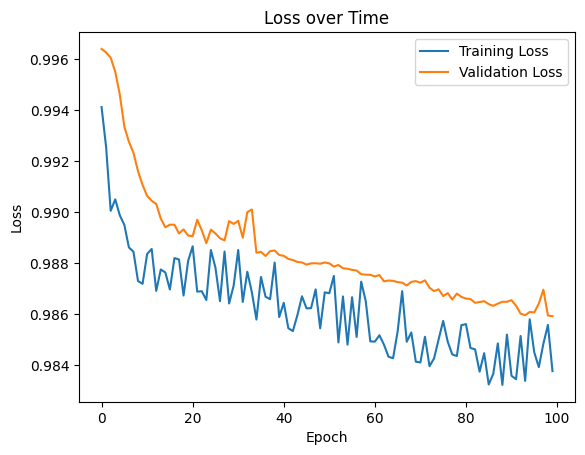

In [113]:
# Plotting the loss history and validation loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()
plt.show()


In [114]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume, pred_mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """
    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        
        # Show the ground truth mask slice
        axs[0].imshow(image_volume[slice_index], cmap='gray')
        axs[0].imshow(mask_volume[slice_index], alpha=0.5, cmap='Reds')  # Overlay mask
        axs[0].set_title('Image with Ground Truth Mask')
        axs[0].axis('off')

        # Show the predicted mask slice
        axs[1].imshow(image_volume[slice_index], cmap='gray')
        axs[1].imshow(pred_mask_volume[slice_index], alpha=0.5, cmap='Blues')  # Overlay mask
        axs[1].set_title('Image with Predicted Mask')
        axs[1].axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    images = torch.from_numpy(loaded_data[series_uid]['images'].astype(np.float32))
    # Add a channel dimension (assuming grayscale images)
    images = images.unsqueeze(0)
    # Add a batch dimension
    images = images.unsqueeze(0)
    # Ensure the tensor is on the correct device
    images = images.to(device)
    outputs = model(images)  # Get the model's predictions

print(outputs.min())  # Example output shape

# The outputs are likely in the form of logits or probabilities. 
# You might need to apply a threshold or take the argmax to get the final predicted mask.
# This depends on how your model was trained.


pred_mask_volume = (outputs > 1.5).float().squeeze(0)[0].cpu().numpy()  # Example for a multi-class segmentation model


# Example usage with the first loaded series (assuming loaded_data is available)
print(outputs.sum())
visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'], pred_mask_volume)

tensor(-1.5723, device='cuda:0')
tensor(-539397.5625, device='cuda:0')


interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…